<a href="https://colab.research.google.com/github/Sarah0711/CUDA-Vision-Lab/blob/main/Activation_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://)#Import Modules

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn08-21
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp


#Check For GPU

In [ ]:
if torch.cuda.is_available:
  avDev = torch.device("cuda")
else:
  avDev = torch.device("cpu")
print(avDev)

cuda


#Set Seed

In [ ]:
seed = 1
torch.manual_seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True

#Utility for Displaying Images, Error Curve 

In [ ]:
def show_images(img,labels):
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [ ]:
def plot_error_curve(errors):
  plt.suptitle('Learning Curve', fontsize=20)
  plt.xlabel('Iterations', fontsize=18)
  plt.ylabel('Classification Error', fontsize=16)
  plt.plot(np.array(errors))

#Load Data

In [ ]:
transform = transforms.Compose([      
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]) 
test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

train_dataset = dsets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = dsets.CIFAR10('./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 100
n_iters = 50000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

[link text](https://)#Make Data Iterable

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


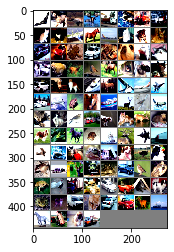

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

dataiter = train_loader.__iter__()
images, labels = dataiter.next()

show_images(torchvision.utils.make_grid(images),labels)

#Define The Class

In [ ]:
import torch.nn.functional as F

class CNNModel(nn.Module):
  def __init__(self,poolingType,layerType):
      super(CNNModel, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3,padding=1)
      self.batchnorm1 = nn.BatchNorm2d(64)
      self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1)
      self.batchnorm2 = nn.BatchNorm2d(128)
      self.pool = poolingType
      self.layer = layerType
      if(layerType == 'FC'):
        self.fc1 = nn.Linear(8192, 4000)
        self.fc2 = nn.Linear(4000,1000)
        self.fc3 = nn.Linear(1000,10)
      elif(layerType == 'CV'):
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(8,8))

  def forward(self, x):
    if(self.pool == 'maxpool'):
      x = F.relu(F.max_pool2d(self.batchnorm1(self.conv1(x)), kernel_size = 2,stride =2))
      x = F.relu(F.max_pool2d((self.batchnorm2(self.conv2(x))),  kernel_size = 2,stride =2))
    if(self.pool == 'avgpool'):
      x = F.relu(F.avg_pool2d(self.batchnorm1(self.conv1(x)), kernel_size = 2,stride =2))
      x = F.relu(F.avg_pool2d((self.batchnorm2(self.conv2(x))),  kernel_size = 2,stride =2))

    if(self.layer == 'FC'):
      x = x.view(-1, 8192)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
    elif(self.layer == 'CV'):
      x = self.conv3(x)
      x = x.view(batch_size,10)
    x = F.log_softmax(x)
    # print(x)
    return x

#Initialize Model,Learning Rate, Optimizer and Momentum

In [ ]:

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
momentum =0.9
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9, nesterov=True)

#Train The Model

In [ ]:
def train(args,test=False):
  poolingType = args[0]
  print("Chosen Pooling Type:",poolingType)
  layerType = args[1]
  print("Chosen Layer Type:",layerType)
  optimizer_chosen = args[2]
  print("Chosen Optimizer:",optimizer_chosen)
  model = CNNModel(poolingType,layerType)
  if(optimizer_chosen == torch.optim.SGD):
    optimizer = optimizer_chosen(model.parameters(), lr = learning_rate, momentum=0.9, nesterov=True)
  else:
    optimizer = optimizer_chosen(model.parameters(), lr = learning_rate)
#######################
#  USE GPU FOR MODEL  #
#######################
 
  if torch.cuda.is_available():
    model.cuda()
  max_accuracy = 0
  min_loss = np.inf
  iter = 0
  epochs_no_improve = 0
  number_of_epoch_stop =10
  classification_error = []
  for epoch in range(num_epochs):
    print("epoch:",epoch)
    for i, (images, labels) in enumerate(train_loader):
        
      #######################
      #  USE GPU FOR MODEL  #
      #######################
      if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()

      # Clear gradients w.r.t. parameters
      optimizer.zero_grad()
        
      # Forward pass to get output/logits
      outputs = model(images)
      # Calculate Loss: softmax --> cross entropy loss
      # if(layerType == 'CV'):
      #   outputs = outputs.view(100,10)
      loss = criterion(outputs, labels)
        
      # Getting gradients w.r.t. parameters
      loss.backward()
        
      # Updating parameters
      optimizer.step()
        
      iter += 1
        
      if iter % 500 == 0:
          # Calculate Accuracy         
          correct = 0
          total = 0
          # Iterate through test dataset
          for images, labels in test_loader:
              #######################
              #  USE GPU FOR MODEL  #
              #######################
              if torch.cuda.is_available():
                  images = images.cuda()
                
              # Forward pass only to get logits/output

              outputs = model(images)
              
              # Get predictions from the maximum value
              _, predicted = torch.max(outputs.data, 1)
                
              # Total number of labels
              total += labels.size(0)
                
              # Total correct predictions
              correct += (predicted.cpu() == labels.cpu()).sum().float()

            
          accuracy = 100. * correct / total
          classification_error.append((100-accuracy))
            
          # Print Loss
          print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
          if accuracy > max_accuracy:
  # Save the model
             torch.save(model, './model.pth')
             epochs_no_improve = 0
             max_accuracy = accuracy
             min_loss = loss.item()
  
          else:
            epochs_no_improve += 1
  # Check early stopping condition
      if epochs_no_improve == number_of_epoch_stop:
        print('Early stopping!' )
        if test:
          return model
        return m in_loss
         
  print("Final Loss:",loss)
  if test:
    return model
  return min_loss


#Define Space For Hyperopt

In [ ]:
poolingType = ['maxpool','avgpool']
layerType = ['FC']
optimizers = [torch.optim.SGD,torch.optim.Adam]
space = [hp.choice('Pooling Type',poolingType),hp.choice('Layer Type',layerType),hp.choice('Optimizers',optimizers)]

In [ ]:
best_classifier = fmin(train,space,algo=tpe.suggest,max_evals=6)
chosen_pooling = poolingType[(best_classifier['Pooling Type'])]
optimizer = optimizers[(best_classifier['Optimizers'])]
chosen_layerType = layerType[(best_classifier['Layer Type'])]


Chosen Pooling Type:
avgpool
Chosen Layer Type:
FC
Chosen Optimizer:
<class 'torch.optim.adam.Adam'>
epoch:
0
  0%|          | 0/6 [00:03<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Iteration: 500. Loss: 2.3034911155700684. Accuracy: 9.979999542236328
epoch:
1


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CNNModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Iteration: 1000. Loss: 2.290036201477051. Accuracy: 10.670000076293945
epoch:
2
Iteration: 1500. Loss: 2.3259780406951904. Accuracy: 10.0
epoch:
3
Iteration: 2000. Loss: 2.350125551223755. Accuracy: 9.989999771118164
epoch:
4
Iteration: 2500. Loss: 2.308865785598755. Accuracy: 10.010000228881836
epoch:
5
Iteration: 3000. Loss: 2.3090403079986572. Accuracy: 10.0
epoch:
6
Iteration: 3500. Loss: 2.3109827041625977. Accuracy: 10.0
epoch:
7
Iteration: 4000. Loss: 2.2989137172698975. Accuracy: 10.0
epoch:
8
Iteration: 4500. Loss: 2.3061795234680176. Accuracy: 10.0
epoch:
9
Iteration: 5000. Loss: 2.294109582901001. Accuracy: 10.0
epoch:
10
Iteration: 5500. Loss: 2.3223724365234375. Accuracy: 10.0
epoch:
11
Iteration: 6000. Loss: 2.3021013736724854. Accuracy: 10.0
Early stopping!
Chosen Pooling Type:
avgpool
Chosen Layer Type:
FC
Chosen Optimizer:
<class 'torch.optim.sgd.SGD'>
epoch:
0
Iteration: 500. Loss: 1.2226157188415527. Accuracy: 57.36000061035156
epoch:
1
Iteration: 1000. Loss: 1.11751

In [ ]:
model = train([chosen_pooling,chosen_layerType,optimizer],True)

Chosen Pooling Type: avgpool
Chosen Layer Type: FC
Chosen Optimizer: <class 'torch.optim.sgd.SGD'>
epoch: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration: 500. Loss: 1.010546088218689. Accuracy: 59.36000061035156


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CNNModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch: 1
Iteration: 1000. Loss: 0.897145688533783. Accuracy: 65.12999725341797
epoch: 2
Iteration: 1500. Loss: 0.7571691870689392. Accuracy: 69.23999786376953
epoch: 3
Iteration: 2000. Loss: 0.5685185194015503. Accuracy: 70.30999755859375
epoch: 4
Iteration: 2500. Loss: 0.5517175793647766. Accuracy: 71.95999908447266
epoch: 5
Iteration: 3000. Loss: 0.5393056869506836. Accuracy: 70.80000305175781
epoch: 6
Iteration: 3500. Loss: 0.34592965245246887. Accuracy: 72.31999969482422
epoch: 7
Iteration: 4000. Loss: 0.32342594861984253. Accuracy: 72.66999816894531
epoch: 8
Iteration: 4500. Loss: 0.20201045274734497. Accuracy: 72.43000030517578
epoch: 9
Iteration: 5000. Loss: 0.19259504973888397. Accuracy: 71.91999816894531
epoch: 10
Iteration: 5500. Loss: 0.19299958646297455. Accuracy: 72.27999877929688
epoch: 11
Iteration: 6000. Loss: 0.20411135256290436. Accuracy: 70.91000366210938
epoch: 12
Iteration: 6500. Loss: 0.2714109718799591. Accuracy: 72.66999816894531
epoch: 13
Iteration: 7000. Loss:

#Equivalent Using Convolution


In [ ]:
model =  train(['maxpool','CV',torch.optim.SGD],True)
# poolingType = ['maxpool','avgpool']
# layerType = ['FC']
# optimizers = [torch.optim.SGD,torch.optim.Adam]

Chosen Pooling Type: maxpool
Chosen Layer Type: CV
Chosen Optimizer: <class 'torch.optim.sgd.SGD'>
epoch: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration: 500. Loss: 2.2388734817504883. Accuracy: 13.149999618530273
epoch: 1


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CNNModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Iteration: 1000. Loss: 2.0977399349212646. Accuracy: 18.850000381469727
epoch: 2
Iteration: 1500. Loss: 2.057541608810425. Accuracy: 18.770000457763672
epoch: 3
Iteration: 2000. Loss: 1.8790907859802246. Accuracy: 29.709999084472656
epoch: 4
Iteration: 2500. Loss: 1.739916205406189. Accuracy: 41.220001220703125
epoch: 5
Iteration: 3000. Loss: 1.525068998336792. Accuracy: 44.310001373291016
epoch: 6
Iteration: 3500. Loss: 1.8077179193496704. Accuracy: 42.369998931884766
epoch: 7
Iteration: 4000. Loss: 1.5954593420028687. Accuracy: 44.86000061035156
epoch: 8
Iteration: 4500. Loss: 1.516025424003601. Accuracy: 47.0099983215332
epoch: 9
Iteration: 5000. Loss: 1.3760290145874023. Accuracy: 47.790000915527344
epoch: 10
Iteration: 5500. Loss: 1.259523868560791. Accuracy: 49.88999938964844
epoch: 11
Iteration: 6000. Loss: 1.3768516778945923. Accuracy: 50.20000076293945
epoch: 12
Iteration: 6500. Loss: 1.4796748161315918. Accuracy: 47.33000183105469
epoch: 13
Iteration: 7000. Loss: 1.2538001537

In [ ]:
model =  train(['maxpool','FC',torch.optim.SGD],True)


Chosen Pooling Type: maxpool
Chosen Layer Type: FC
Chosen Optimizer: <class 'torch.optim.sgd.SGD'>
epoch: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration: 500. Loss: 0.8405886888504028. Accuracy: 62.29999923706055


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CNNModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch: 1
Iteration: 1000. Loss: 0.8560594320297241. Accuracy: 68.69999694824219
epoch: 2
Iteration: 1500. Loss: 0.9073484539985657. Accuracy: 70.83000183105469
epoch: 3
Iteration: 2000. Loss: 0.6700717806816101. Accuracy: 71.70999908447266
epoch: 4
Iteration: 2500. Loss: 0.5282320976257324. Accuracy: 73.0
epoch: 5
Iteration: 3000. Loss: 0.6033928990364075. Accuracy: 73.05999755859375
epoch: 6
Iteration: 3500. Loss: 0.39186203479766846. Accuracy: 75.88999938964844
epoch: 7
Iteration: 4000. Loss: 0.2531437277793884. Accuracy: 75.12000274658203
epoch: 8
Iteration: 4500. Loss: 0.4993027448654175. Accuracy: 75.83000183105469
epoch: 9
Iteration: 5000. Loss: 0.4157141149044037. Accuracy: 76.36000061035156
epoch: 10
Iteration: 5500. Loss: 0.335289865732193. Accuracy: 75.81999969482422
epoch: 11
Iteration: 6000. Loss: 0.3779495656490326. Accuracy: 76.12999725341797
epoch: 12
Iteration: 6500. Loss: 0.30934396386146545. Accuracy: 76.44000244140625
epoch: 13
Iteration: 7000. Loss: 0.44010069966316

In [ ]:
model =  train(['maxpool','FC',torch.optim.SGD],True)


Chosen Pooling Type: maxpool
Chosen Layer Type: FC
Chosen Optimizer: <class 'torch.optim.sgd.SGD'>
epoch: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration: 500. Loss: 1.181728482246399. Accuracy: 58.529998779296875


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CNNModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch: 1
Iteration: 1000. Loss: 0.8710521459579468. Accuracy: 68.69000244140625
epoch: 2
Iteration: 1500. Loss: 0.7823688983917236. Accuracy: 71.83999633789062
epoch: 3
Iteration: 2000. Loss: 0.782470166683197. Accuracy: 72.44999694824219
epoch: 4
Iteration: 2500. Loss: 0.6097639203071594. Accuracy: 73.62999725341797
epoch: 5
Iteration: 3000. Loss: 0.5348471999168396. Accuracy: 74.37000274658203
epoch: 6
Iteration: 3500. Loss: 0.39688053727149963. Accuracy: 75.69999694824219
epoch: 7
Iteration: 4000. Loss: 0.3799809515476227. Accuracy: 76.05999755859375
epoch: 8
Iteration: 4500. Loss: 0.29922425746917725. Accuracy: 75.62000274658203
epoch: 9
Iteration: 5000. Loss: 0.36949118971824646. Accuracy: 76.08000183105469
epoch: 10
Iteration: 5500. Loss: 0.21551956236362457. Accuracy: 76.72000122070312
epoch: 11
Iteration: 6000. Loss: 0.2608996629714966. Accuracy: 75.41999816894531
epoch: 12
Iteration: 6500. Loss: 0.36195147037506104. Accuracy: 76.75
epoch: 13
Iteration: 7000. Loss: 0.1906569898

#Visualize the Activations 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


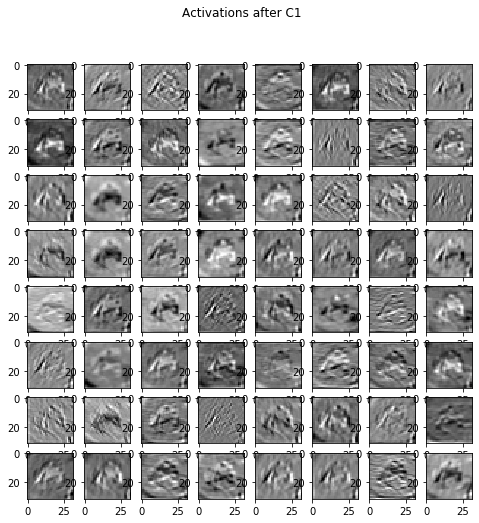

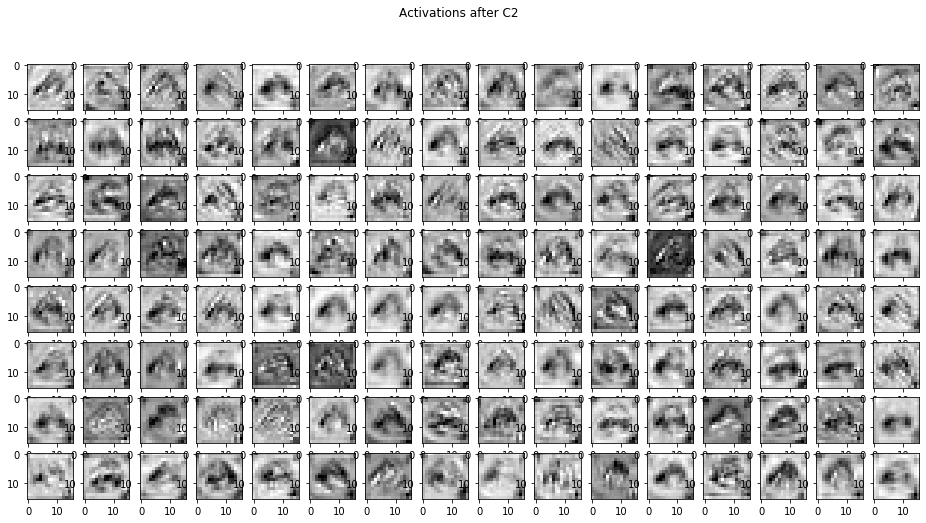

In [ ]:
 
activation = {} 
def get_activation(name):    
  def hook(model, input, output):         
    activation[name] = output.detach()     
  return hook 
 
model.conv1.register_forward_hook(get_activation('conv1')) 
data, _ = train_dataset[0] 
data.unsqueeze_(0) 
output = model(data.cuda()) 
 
act = activation['conv1'].squeeze() 
act = act.cpu().numpy()
fig=plt.figure(figsize=(8, 8))
fig.suptitle("Activations after C1")
columns = 8
rows = 8
image_number=1
for i in range(64):
    fig.add_subplot(rows, columns, image_number)
    image_number = image_number + 1
    plt.imshow(act[i-1],cmap='gray')

plt.show()
plt.close()

model.conv2.register_forward_hook(get_activation('conv2')) 
data, _ = train_dataset[0] 
data.unsqueeze_(0) 
output = model(data.cuda()) 
 
act = activation['conv2'].squeeze() 
act = act.cpu().numpy()
fig=plt.figure(figsize=(16, 8))
fig.suptitle("Activations after C2")
columns = 16
rows = 8
image_number=1
for i in range(128):
    fig.add_subplot(rows, columns, image_number)
    image_number = image_number + 1
    plt.imshow(act[i-1],cmap='gray')
plt.show()
plt.close()


#Visualize The Filters

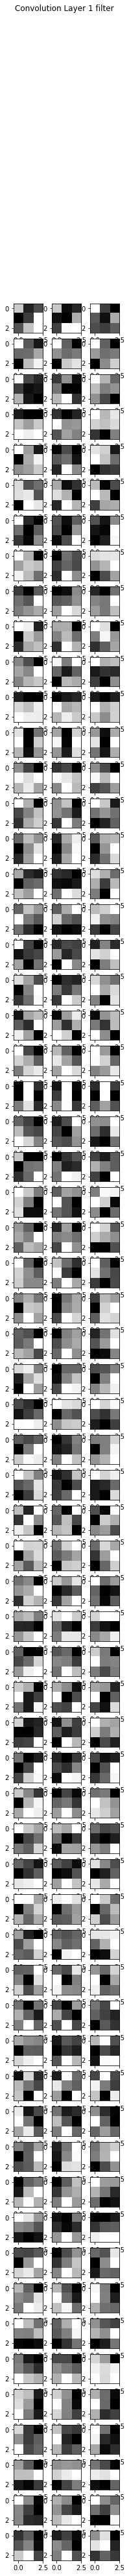

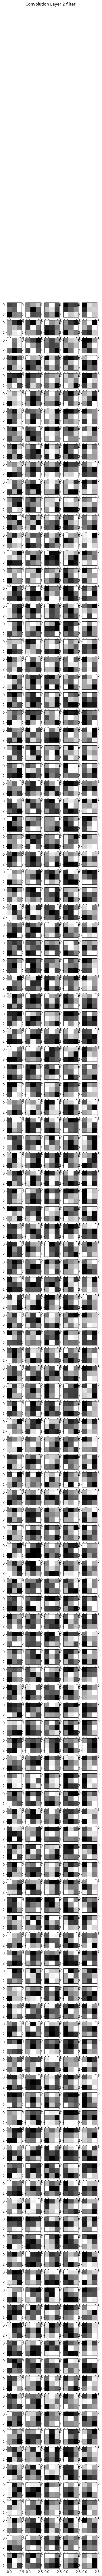

In [ ]:
weight = model.conv1.weight.data.cpu().numpy()
weight = (weight-np.min(weight,axis=0))/(np.max(weight,axis=0)-np.min(weight,axis=0))

columns = weight.shape[1]
rows = weight.shape[0]
fig=plt.figure(figsize=(columns,rows))
fig.suptitle("Convolution Layer 1 filter")
image_number=1
for i in range(weight.shape[0]):
  for j in range(weight.shape[1]):
    fig.add_subplot(rows, columns, image_number)
    image_number = image_number + 1
    plt.imshow(weight[i][j],cmap='gray')

plt.show()
plt.close()


weight2 = model.conv2.weight.data.cpu().numpy()
weight2 = (weight2-np.min(weight2,axis=0))/(np.max(weight2,axis=0)-np.min(weight2,axis=0))

columns = weight2.shape[1]
columns = 5
rows = weight2.shape[0]
fig=plt.figure(figsize=(columns, rows))

fig.suptitle("Convolution Layer 2 filter")

image_number=1
for i in range(rows):
  for j in range(columns):
    fig.add_subplot(rows, columns, image_number)
    image_number = image_number + 1
    plt.imshow(weight2[i][j],cmap='gray')
plt.show()